In [393]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit

In [394]:
import warnings
warnings.filterwarnings("ignore")

In [395]:
if torch.cuda.is_available():
    print("CUDA is available on this machine.")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Found CUDA-enabled device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available on this machine.")

CUDA is available on this machine.
Found CUDA-enabled device: NVIDIA GeForce RTX 2060


In [396]:
class TorchVisionDataset(Dataset):
    def __init__(self, data_dic, transform=None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform
        self.corrupted_count = 0

    def __len__(self):
        return len(self.file_paths)

    
    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        try:
            image = Image.open(file_path)

            if image.mode == 'RGBA':
                image = image.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            return image, label
        
        except Exception as e:
            self.corrupted_count += 1
            print(self.corrupted_count)
            return torch.zeros(3, 224, 224), label

In [397]:
# images = glob.glob("data/*/*/*")
images = glob.glob("test-data/*/*")
images = np.array(images)
labels = np.array([f.split("\\")[-2] for f in images])

print(len(images))
print(labels.size)
print(images[0])
print(labels[0])

165
165
test-data\Black\ball_of_lint.jpeg
Black


In [398]:
classes = np.unique(labels).flatten()
print(classes)
labels_int = np.zeros(labels.size, dtype=np.int64)
print(labels_int.shape)

for ii, jj in enumerate(classes):
    labels_int[labels == jj] = ii 

['Black' 'Blue' 'Green' 'Other']
(165,)


In [399]:
for ii in range(4):
    print("Label ", ii, ":", (labels_int == ii).sum())

Label  0 : 48
Label  1 : 55
Label  2 : 35
Label  3 : 27


In [400]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
sss.get_n_splits(images, labels_int)
dev_index, test_index = next(sss.split(images, labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [401]:
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
sss2.get_n_splits(dev_images, dev_labels)
train_index, val_index = next(sss2.split(dev_images, dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 


In [402]:
print("Train set:", len(train_images))
print("Val set:", len(val_images))
print("Test set:", len(test_images))

Train set: 105
Val set: 27
Test set: 33


In [403]:
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [404]:
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.4120, 0.3768, 0.3407],std=[0.2944,0.2759,0.2598])])

torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.4120, 0.3768, 0.3407],std=[0.2944,0.2759,0.2598])])

In [405]:
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

In [406]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

In [407]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the statistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [408]:
print(get_dataset_stats(trainloader))

(tensor([ 0.3771,  0.1845, -0.0868]), tensor([0.5670, 0.5823, 0.6487]))


In [409]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [410]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


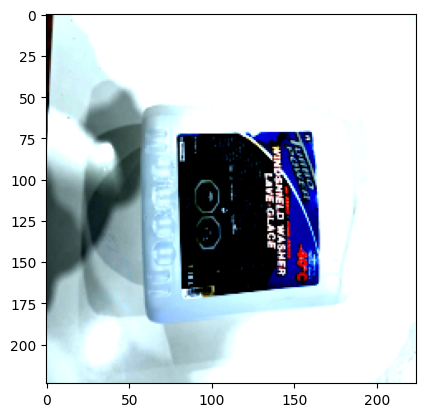

In [411]:
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [412]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [413]:
net = ResNet18(4)
net.to(device)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [414]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [415]:
nepochs = 20
PATH = './resnet18.pth' # Path to save the best model

best_loss = 1e+20
patience = 3  # Number of epochs to wait before early stopping
count = 0

for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end=' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i + 1):.3f}') 
        
        # Early stopping
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
            count = 0  # Reset count if we found a better model
        else:
            count += 1
            if count >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
        
print('Finished Training')


1,  train loss: 1.945, val loss: 1.320
Saving model
2,  train loss: 1.461, val loss: 1.143
Saving model
3,  train loss: 1.301, val loss: 1.087
Saving model
4,  train loss: 1.087, val loss: 1.022
Saving model
5,  train loss: 1.014, val loss: 0.995
Saving model
6,  train loss: 0.874, val loss: 0.954
Saving model
7,  train loss: 0.785, val loss: 0.934
Saving model
8,  train loss: 0.731, val loss: 0.892
Saving model
9,  train loss: 0.676, val loss: 0.907
10,  train loss: 0.585, val loss: 0.895
11,  train loss: 0.606, val loss: 0.893
Early stopping at epoch 11
Finished Training


In [416]:
net = ResNet18(4)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [417]:
class_correct = [0 for _ in range(4)]
class_total = [0 for _ in range(4)]
overall_correct = 0
overall_total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
            overall_correct += (predicted[i] == label).item()
            overall_total += 1

for i in range(4):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy of class {i}: {accuracy:.2f} %')

overall_accuracy = 100 * overall_correct / overall_total if overall_total > 0 else 0
print(f'Overall accuracy: {overall_accuracy:.2f} %')


Accuracy of class 0: 90.00 %
Accuracy of class 1: 81.82 %
Accuracy of class 2: 71.43 %
Accuracy of class 3: 0.00 %
Overall accuracy: 69.70 %


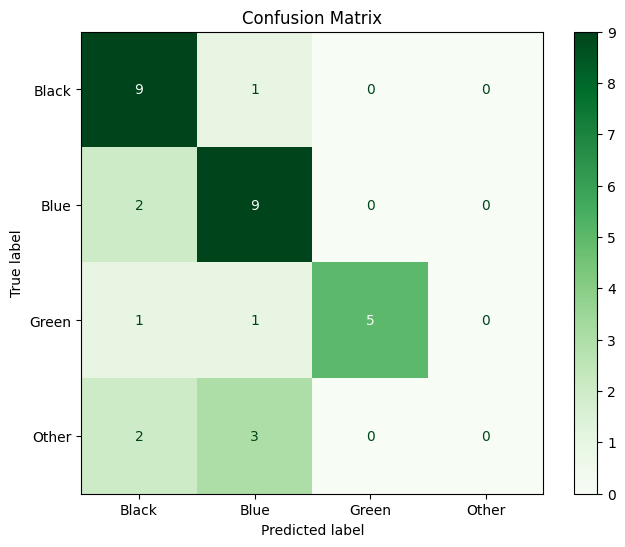

In [422]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

classes = ['Black', 'Blue', 'Green', 'Other']

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()
